In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

class GraphRMDPEnv:
    def __init__(self, state_size, action_size, ambiguity_size, seed=42):
        self.chosen_ambiguity = None
        self.location = None
        self.state_size = state_size
        self.action_size = action_size
        self.ambiguity_size = ambiguity_size
        np.random.seed(seed)

        self.rewards = np.random.random((action_size, state_size, state_size))

        un_normalized = np.random.random((ambiguity_size, action_size, state_size, state_size))
        self.ambiguity_set = un_normalized / np.sum(un_normalized, axis=-1, keepdims=True)

        un_normalized = np.random.random(ambiguity_size)
        self.ambiguity_probs = un_normalized / un_normalized.sum()

    def reset(self, chosen_ambiguity):
        self.location = 0
        self.chosen_ambiguity = chosen_ambiguity
        return self.location

    def step(self, action):
        next_states_prob = self.ambiguity_set[self.chosen_ambiguity, action, self.location, :]
        next_state = np.random.choice(self.state_size, 1, p=next_states_prob)[0]
        reward = self.rewards[action, self.location, next_state]
        self.location = next_state
        return self.location, reward

In [2]:
def epsilon_greedy_action(state, q_table, epsilon):
    r = np.random.random(1)[0]
    if r < epsilon:
        return np.random.choice(q_table.shape[1], 1)[0]
    else:
        return np.argmax(q_table[state, :])


def q_learning(env, n_episodes, n_steps, learning_rate, gamma, epsilon_min, epsilon, epsilon_decay, chosen_ambiguity=None):
    q_table = np.zeros((env.state_size, env.action_size))
    episode_rewards = []
    for episode in tqdm(range(n_episodes)):
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        if chosen_ambiguity is not None:
            state = env.reset(chosen_ambiguity=chosen_ambiguity)
        else:
            state = env.reset()
        episode_reward = 0
        for i in range(n_steps):
            action = epsilon_greedy_action(state, q_table, epsilon)
            next_state, reward = env.step(action)
            episode_reward += reward
            q_table[state, action] += learning_rate * (
                reward + gamma * np.max(q_table[next_state, :])
                - q_table[state, action]
            )
            state = next_state
        episode_rewards.append(episode_reward)
    return episode_rewards, q_table

In [3]:
state_size = 10
act_size = 4
amb_size = 5
check_steps = 100
check_gamma = 0.9
graph_env = GraphRMDPEnv(state_size=state_size, action_size=act_size, ambiguity_size=amb_size)

In [4]:
# best policy for each of ambiguity sets
rewards = []
q_tables = np.zeros((amb_size, state_size, act_size))
policies = np.zeros((amb_size, state_size), dtype=np.int32)
for i in range(amb_size):
    reward_history, q_tables[i] = q_learning(graph_env, n_episodes=10000, n_steps=check_steps, learning_rate=0.1, 
                                  gamma=check_gamma, epsilon_min=0.1, epsilon=1, epsilon_decay=0.95, chosen_ambiguity=i)
    policies[i] = np.argmax(q_tables[i], axis=1)
    rewards.append(reward_history)
    #plt.plot(reward_history)
    #plt.show()

100%|██████████| 10000/10000 [00:47<00:00, 212.14it/s]


In [5]:
class BigMDPEnv:
    def __init__(self, env: GraphRMDPEnv):
        self.state_size = env.ambiguity_size * env.state_size
        self.action_size = env.action_size

        self.location = None
        self.rmdp_env = env
        self.transition = np.zeros((env.ambiguity_size, env.state_size, env.action_size, env.ambiguity_size, env.state_size))
        for amb_src in range(env.ambiguity_size):
            for state_src in range(env.state_size):
                for action in range(env.action_size):
                    for amb_dst in range(env.ambiguity_size):
                        for state_dst in range(env.state_size):
                            self.transition[amb_src, state_src, action, amb_dst, state_dst] = (
                                env.ambiguity_set[amb_dst, action, state_src, state_dst] *
                                env.ambiguity_probs[amb_dst]
                            )
        self.reshaped_transition = self.transition.reshape((env.ambiguity_size, env.state_size, env.action_size, -1))

    def reset(self):
        chosen_ambiguity = np.random.choice(self.rmdp_env.ambiguity_size, 1, p=self.rmdp_env.ambiguity_probs)[0]
        self.location = (chosen_ambiguity, 0)
        return self.location[0] * self.rmdp_env.state_size + self.location[1]

    def step(self, action):
        next_states_prob = self.reshaped_transition[self.location[0], self.location[1], action]
        next_state = np.random.choice(self.state_size, 1, p=next_states_prob)[0]
        next_location = (next_state // self.rmdp_env.state_size, next_state % self.rmdp_env.ambiguity_size)
        reward = self.rmdp_env.rewards[action, self.location[1], next_location[1]]  # doesn't depend on ambiguity
        self.location = next_location
        return next_state, reward
    
print('Probability of going from (0, 0) (ambiguity zero, state zero) to other states with action 0:')
print(BigMDPEnv(graph_env).transition[0, 0, 1].sum()) # making sure the definition makes sense (this should be equal to 1)

Probability of going from (0, 0) (ambiguity zero, state zero) to other states with action 0:
1.0


100%|██████████| 10000/10000 [00:45<00:00, 219.43it/s]


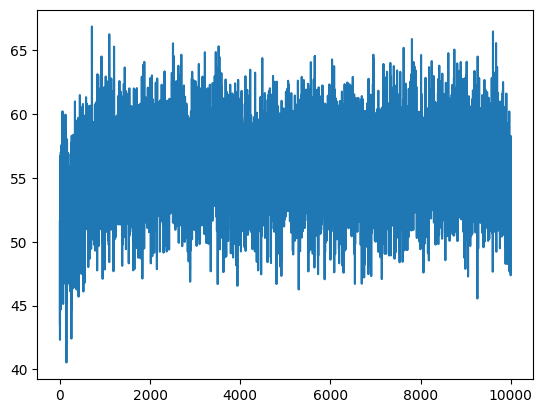

In [6]:
big_mdp_env = BigMDPEnv(graph_env)

# best policy for big mdp
big_rewards, big_q_table = q_learning(big_mdp_env, n_episodes=10000, n_steps=check_steps, learning_rate=0.1, 
                              gamma=check_gamma, epsilon_min=0.1, epsilon=1, epsilon_decay=0.95)
big_policy = np.argmax(big_q_table, axis=1).reshape((amb_size, state_size))
big_q_table = big_q_table.reshape((amb_size, state_size, act_size))
plt.plot(big_rewards)
plt.show()

In [7]:
big_policy  # calculated for the big MDP

array([[0, 0, 3, 2, 1, 0, 0, 0, 2, 1],
       [1, 1, 3, 2, 2, 0, 0, 3, 2, 2],
       [3, 1, 3, 0, 2, 0, 2, 3, 0, 2],
       [3, 3, 3, 2, 1, 3, 0, 3, 1, 2],
       [0, 1, 3, 2, 1, 0, 1, 3, 2, 2]])

In [8]:
policies  # calculated for each of ambiguity set distributions independently

array([[0, 2, 3, 2, 2, 0, 0, 2, 3, 3],
       [3, 2, 3, 0, 2, 3, 3, 2, 3, 3],
       [0, 1, 3, 0, 2, 0, 2, 2, 3, 3],
       [0, 2, 3, 0, 2, 1, 2, 2, 3, 1],
       [1, 1, 3, 0, 2, 0, 3, 2, 0, 1]], dtype=int32)

In [9]:
def evaluate_policy_reward(env: GraphRMDPEnv, n_episodes, policy, n_steps):
    all_rewards = []
    for episode in tqdm(range(n_episodes)):
        ambiguity = np.random.choice(env.ambiguity_size, 1, p=env.ambiguity_probs)[0]
        state = env.reset(chosen_ambiguity=ambiguity)
        episode_reward = 0
        for i in range(n_steps):
            action = np.random.choice(env.action_size, 1, p=policy[state, :])[0]
            state, reward = env.step(action)
            episode_reward += reward
        all_rewards.append(episode_reward)
    return all_rewards

big_avg_policy = np.zeros((state_size, act_size))
independent_avg_policies = np.zeros((state_size, act_size))
for s in range(state_size):
    for amb in range(amb_size):
        big_avg_policy[s, big_policy[amb, s]] += graph_env.ambiguity_probs[amb]
        independent_avg_policies[s, policies[amb, s]] += graph_env.ambiguity_probs[amb]

In [10]:
big_avg_rewards = evaluate_policy_reward(graph_env, 10000, big_avg_policy, 100)

100%|██████████| 10000/10000 [01:00<00:00, 164.91it/s]


In [11]:
independent_avg_rewards = evaluate_policy_reward(graph_env, 10000, independent_avg_policies, 100)

100%|██████████| 10000/10000 [01:00<00:00, 166.57it/s]


In [13]:
np.var(big_avg_rewards)

13.925989451632748

In [14]:
np.var(independent_avg_rewards)

8.647052676524206

In [12]:
print(f'big avg policy reward:\t\tf{np.mean(big_avg_rewards)}')
print(f'independent avg policy reward:\t\tf{np.mean(independent_avg_rewards)}')

big avg policy reward:		f49.32951236701233
independent avg policy reward:		f60.57033360958714
